In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier


In [2]:
x = pd.read_csv('dataset_part_3.csv')
y = pd.read_csv('dataset_part_2.csv')['Class'].to_numpy()
x.head()

,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,...,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
0,1.0,6104.959412,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,525.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,677.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,500.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,3170.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
print(y)

[0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 0 0 0 1 1 0 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 0 1
 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [4]:
transform = preprocessing.StandardScaler()
x = transform.fit_transform(x)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

In [6]:
logreg = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier(n_neighbors=5)
tree = DecisionTreeClassifier(random_state=42)
xgb = XGBClassifier( eval_metric='logloss', random_state=42)

logreg.fit(x_train, y_train)
knn.fit(x_train, y_train)
tree.fit(x_train, y_train)
xgb.fit(x_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [7]:
from sklearn.model_selection import cross_val_score
for model,name in [(logreg,"Logistic Regression"), (knn,"KNN"), (tree,"Decision Tree"), (xgb,"XGBoost")]:
 scores = cross_val_score(model, x_train, y_train, cv=5, scoring='accuracy')
 print(f"{name} CV Accuracy: {scores.mean():.3f} ± {scores.std():.3f}")

Logistic Regression CV Accuracy: 0.835 ± 0.065


KNN CV Accuracy: 0.667 ± 0.026
Decision Tree CV Accuracy: 0.806 ± 0.114
XGBoost CV Accuracy: 0.805 ± 0.096


In [8]:
from sklearn.model_selection import GridSearchCV
param_grid = {
 'n_estimators': [50, 100, 200],
 'max_depth': [3, 5, 7],
 'learning_rate': [0.1, 0.01]
 }
xgb_clf = XGBClassifier(eval_metric='logloss', random_state=42)
grid_search = GridSearchCV(xgb_clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(x_train, y_train)
print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_
print("Best CV Accuracy: %.3f" % grid_search.best_score_)


Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Best CV Accuracy: 0.861


In [9]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

y_pred = best_model.predict(x_test)
y_proba = best_model.predict_proba(x_test)[:, 1] # probability of class=1(success)

acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.3f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Failure","Success"]))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

Test Accuracy: 0.833
Classification Report:
              precision    recall  f1-score   support

     Failure       1.00      0.50      0.67         6
     Success       0.80      1.00      0.89        12

    accuracy                           0.83        18
   macro avg       0.90      0.75      0.78        18
weighted avg       0.87      0.83      0.81        18

Confusion Matrix:
 [[ 3  3]
 [ 0 12]]


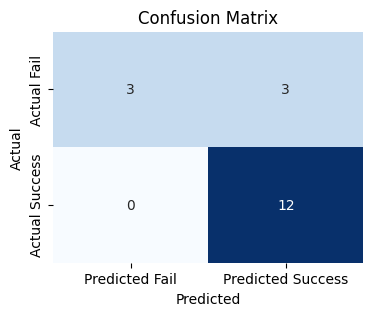

In [10]:
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=["Predicted Fail","Predicted Success"], 
            yticklabels=["Actual Fail","Actual Success"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

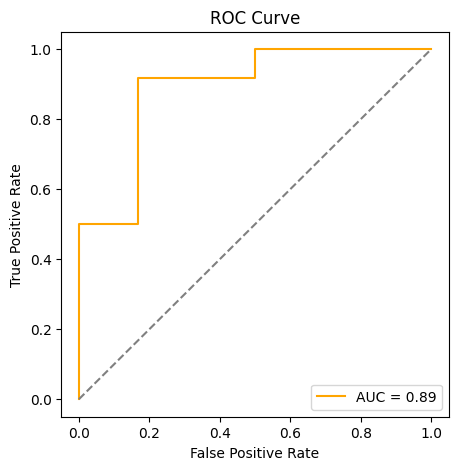

In [11]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}", color='orange')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [12]:
models = {"Logistic": logreg, "KNN": knn, "Decision Tree": tree, "XGBoost": best_model}
for name, model in models.items():
    y_pred = model.predict(x_test)
    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred):.3f}")

Logistic Accuracy: 0.833
KNN Accuracy: 0.667
Decision Tree Accuracy: 0.944
XGBoost Accuracy: 0.833


In [13]:
import pickle
with open('best_model.pkl', 'wb') as f:
    pickle.dump(grid_search.best_estimator_, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(transform, f)

print("Model aur Scaler successfully saved")

Model aur Scaler successfully saved
